**Библиотеки Python для DS (семинары)**

***Урок 4. Практическая работа. Построение модели бинарной классификации***

Используя diabetes-dataset, выполните следующие шаги:

1. Предварительная обработка данных:
— Очистите данные от пропусков (если они есть), обработайте аномалии и нормализуйте данные, если это необходимо.
— Разделите датасет на обучающую и тестовую выборки.

2. Построение модели:
— Используя алгоритм логистической регрессии, постройте модель бинарной классификации для предсказания наличия диабета у пациентов.
— Обучите модель на обучающем наборе данных.

3. Оценка модели:
— Вычислите и проанализируйте метрики точности (accuracy), точности (precision), полноты (recall) и F1-меру для обученной модели на тестовых данных.

Импортируем необходимые библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')
import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

Загризим датасет и посмотрим на признаки

In [3]:
df = pd.read_csv('sample_data/diabetes-dataset.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


***Расшифровка названий столбцов набора данных о диабете, содержащий 2000 записей***

Pregnancies: Количество беременностей пациента

Glucose:	Уровень глюкозы в крови (в мг/дл)

BloodPressure: Уровень артериального давления (в мм рт. ст.)

SkinThickness: Проблемы с кожей, толщина кожи (в мм)

Insulin: Уровень инсулина в крови (в мкЕд/мл)

BMI: Индекс массы тела (в кг/м²)

DiabetesPedigreeFunction: Функция родословной диабета (оценка наследственной предрасположенности)

Age: Возраст пациента (в годах)

Outcome: Целевая переменная (наличие диабета (0 = нет, 1 = да))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [5]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [6]:
df.duplicated().sum()

1256

In [7]:
df = df.drop_duplicates()

In [8]:
df.duplicated().sum()

0

In [9]:
df.nunique()

,0
Pregnancies,17
Glucose,136
BloodPressure,47
SkinThickness,53
Insulin,182
BMI,247
DiabetesPedigreeFunction,505
Age,52
Outcome,2


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,744.0,3.752688,3.335541,0.000,1.000,3.0000,6.0000,17.00
Glucose,744.0,120.892473,31.943115,0.000,99.000,117.0000,140.2500,199.00
BloodPressure,744.0,68.959677,19.317521,0.000,62.000,72.0000,80.0000,122.00
SkinThickness,744.0,20.908602,16.311726,0.000,0.000,23.0000,32.0000,110.00
Insulin,744.0,79.534946,111.745897,0.000,0.000,36.0000,130.0000,744.00
BMI,744.0,32.229704,8.206319,0.000,27.400,32.3000,36.8000,80.60
DiabetesPedigreeFunction,744.0,0.472355,0.326181,0.078,0.244,0.3755,0.6325,2.42
Age,744.0,33.142473,11.751286,21.000,24.000,29.0000,40.2500,81.00
Outcome,744.0,0.340054,0.474046,0.000,0.000,0.0000,1.0000,1.00


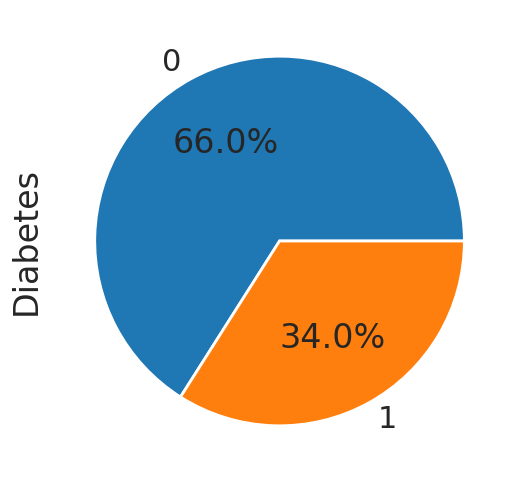

In [11]:
sns.set_style('darkgrid')
sns.set_context('poster')
plt.rcParams['figure.figsize'] = [8,6]
df.groupby('Outcome').size().plot(kind='pie',
                                       y = "Outcome",
                                       label = "Diabetes",
                                       autopct='%1.1f%%');

Наблюдаем ситуацию сильного дисбаланса классов в данных. С долей 66.0% участников, не болеющих диабетом (класс "0"), и 34.0% участников, у которых есть диабет. (класс "1"), ясно, что данный набор данных имеет низкое представительство одного из классов по сравнению с другим.

In [12]:
# Добавим новую категорию по возрасту для анализа
def assign_broader_age_category(row):
  if 0<row['Age']<=18:
    return "children"
  elif 18<row['Age']<=35:
    return "young people"
  elif 35<row['Age']<=65:
    return "adults"
  else:
    return "the elderly"

In [13]:
df['Age_category'] = df.apply(assign_broader_age_category, axis=1)

In [14]:
df['Age_category'].value_counts()

,count
Age_category,
young people,481
adults,250
the elderly,13


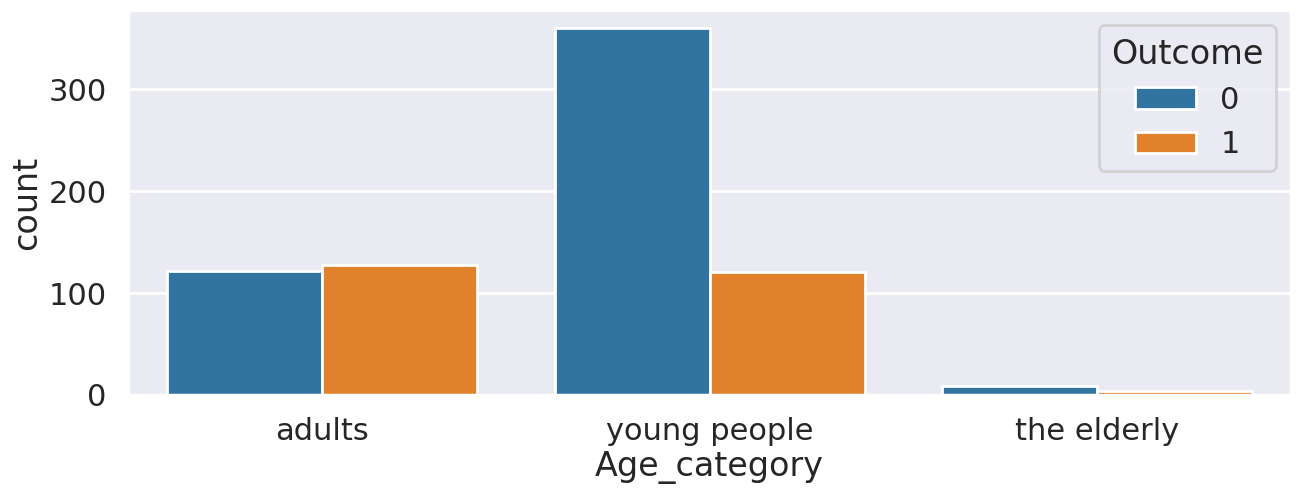

In [15]:
plt.figure(figsize=(15,5))
sns.countplot(x='Age_category',hue='Outcome',data=df)
plt.show()

Людей больных диабетом в возрасте от 35 до 65 лет, незначительно, но больше, чем не страдающих этим недугом.

Люди, которые болеют диабетом, в возрасте от 18 до 35 лет, составляют примерно 36%, от людей не болеющих в этой возрастной группе.


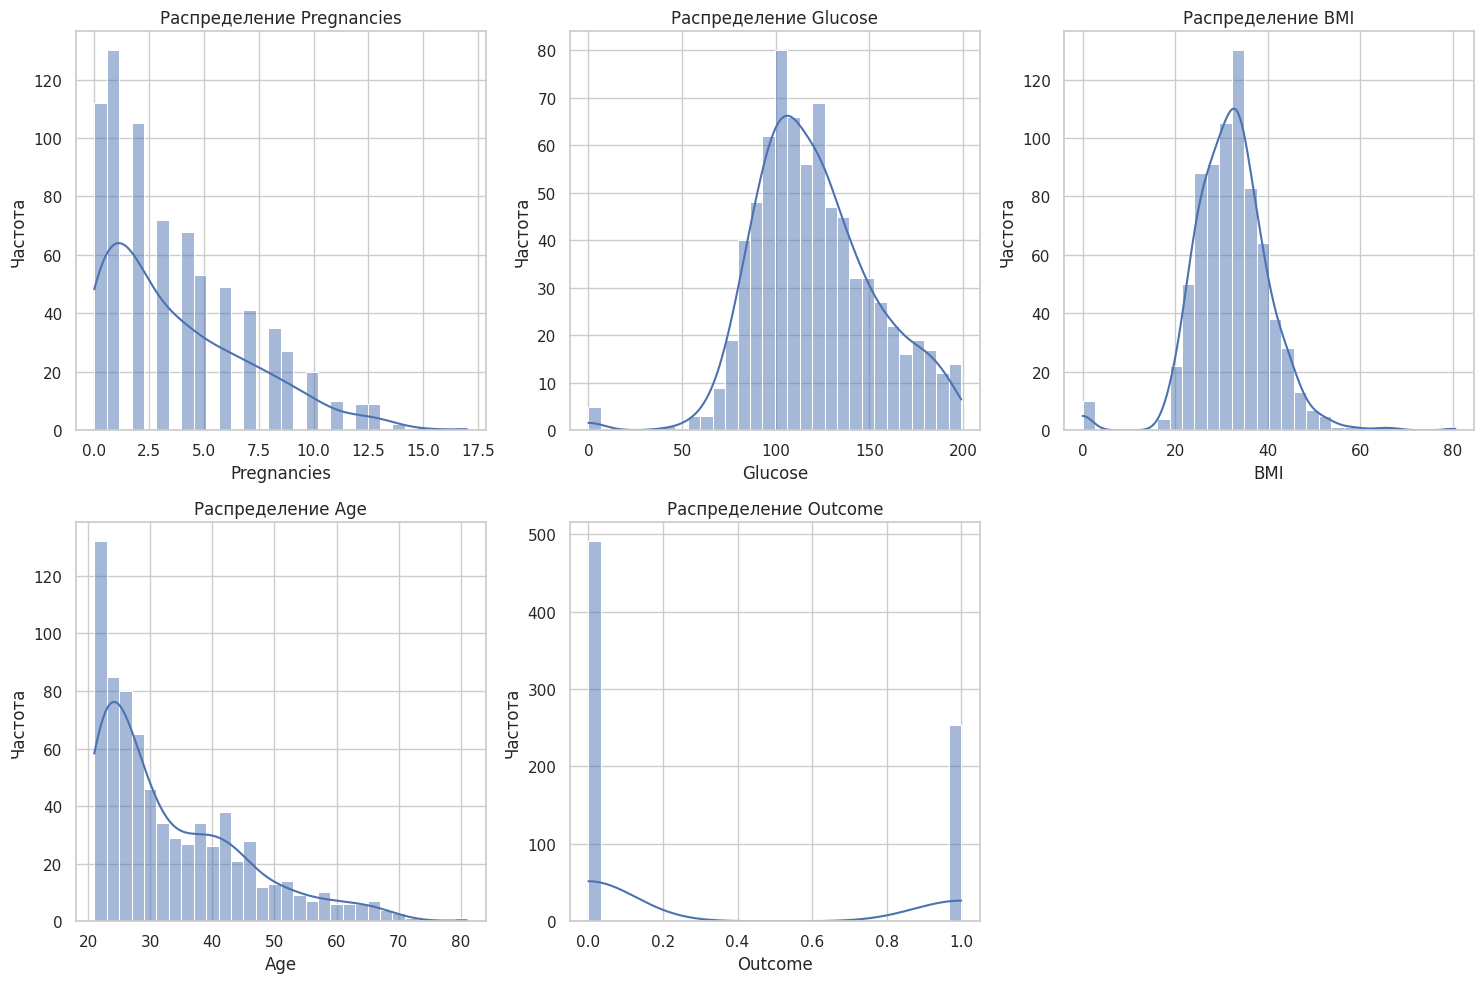

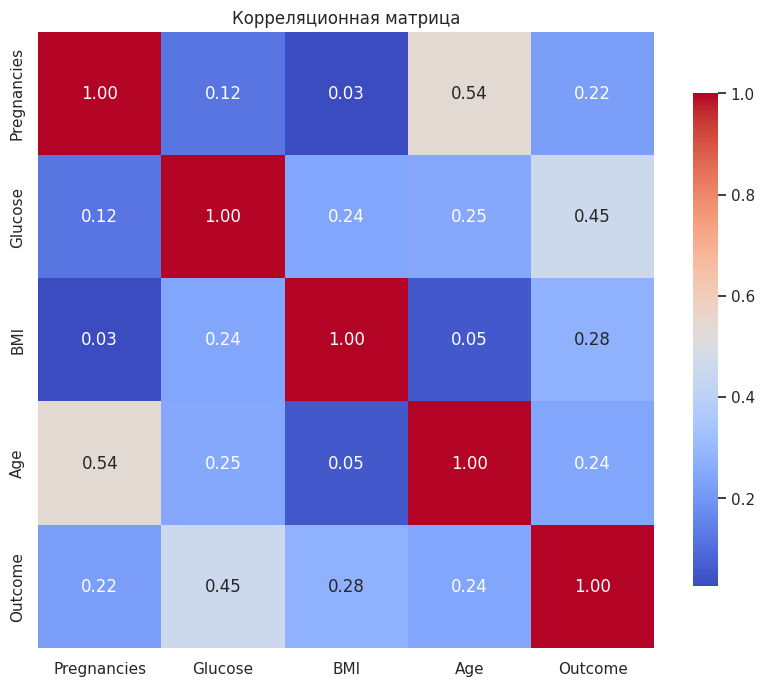

In [16]:
# Установка стиля графиков
sns.set(style="whitegrid")

# 1. Визуализация распределения нескольких выбранных числовых переменных
selected_columns = ['Pregnancies', 'Glucose', 'BMI', 'Age', 'Outcome']
#selected_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

plt.figure(figsize=(15, 10))

for i, column in enumerate(selected_columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

# 2. Визуализация корреляции между выбранными переменными
correlation_matrix = df[selected_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Корреляционная матрица')
plt.show()

In [17]:
sel = alt.selection_single(fields=["Outcome"])
c1= alt.Chart(df).mark_circle().encode(
    x="Age",
    y="Pregnancies",
    color=alt.Color('Outcome')
)
c2= alt.Chart(df).mark_circle().encode(
    x="Glucose",
    y="BMI",
    color=alt.Color('Outcome')
)
c1&c2

alt.VConcatChart(...)

Первый график показывает, что согласно представленным данным чаще всего диабетом болеют женщины, в возрасте от 25 до 50 лет и это заболевание не зависит от количества имеющихся у них детей.

Второй график показывает, что диабет диагностирован у людей с повышенным уровнем глюкозы (нормой считается уровень до 99 мг/дл) и повышенным индексом массы тела (норма до 24,9).


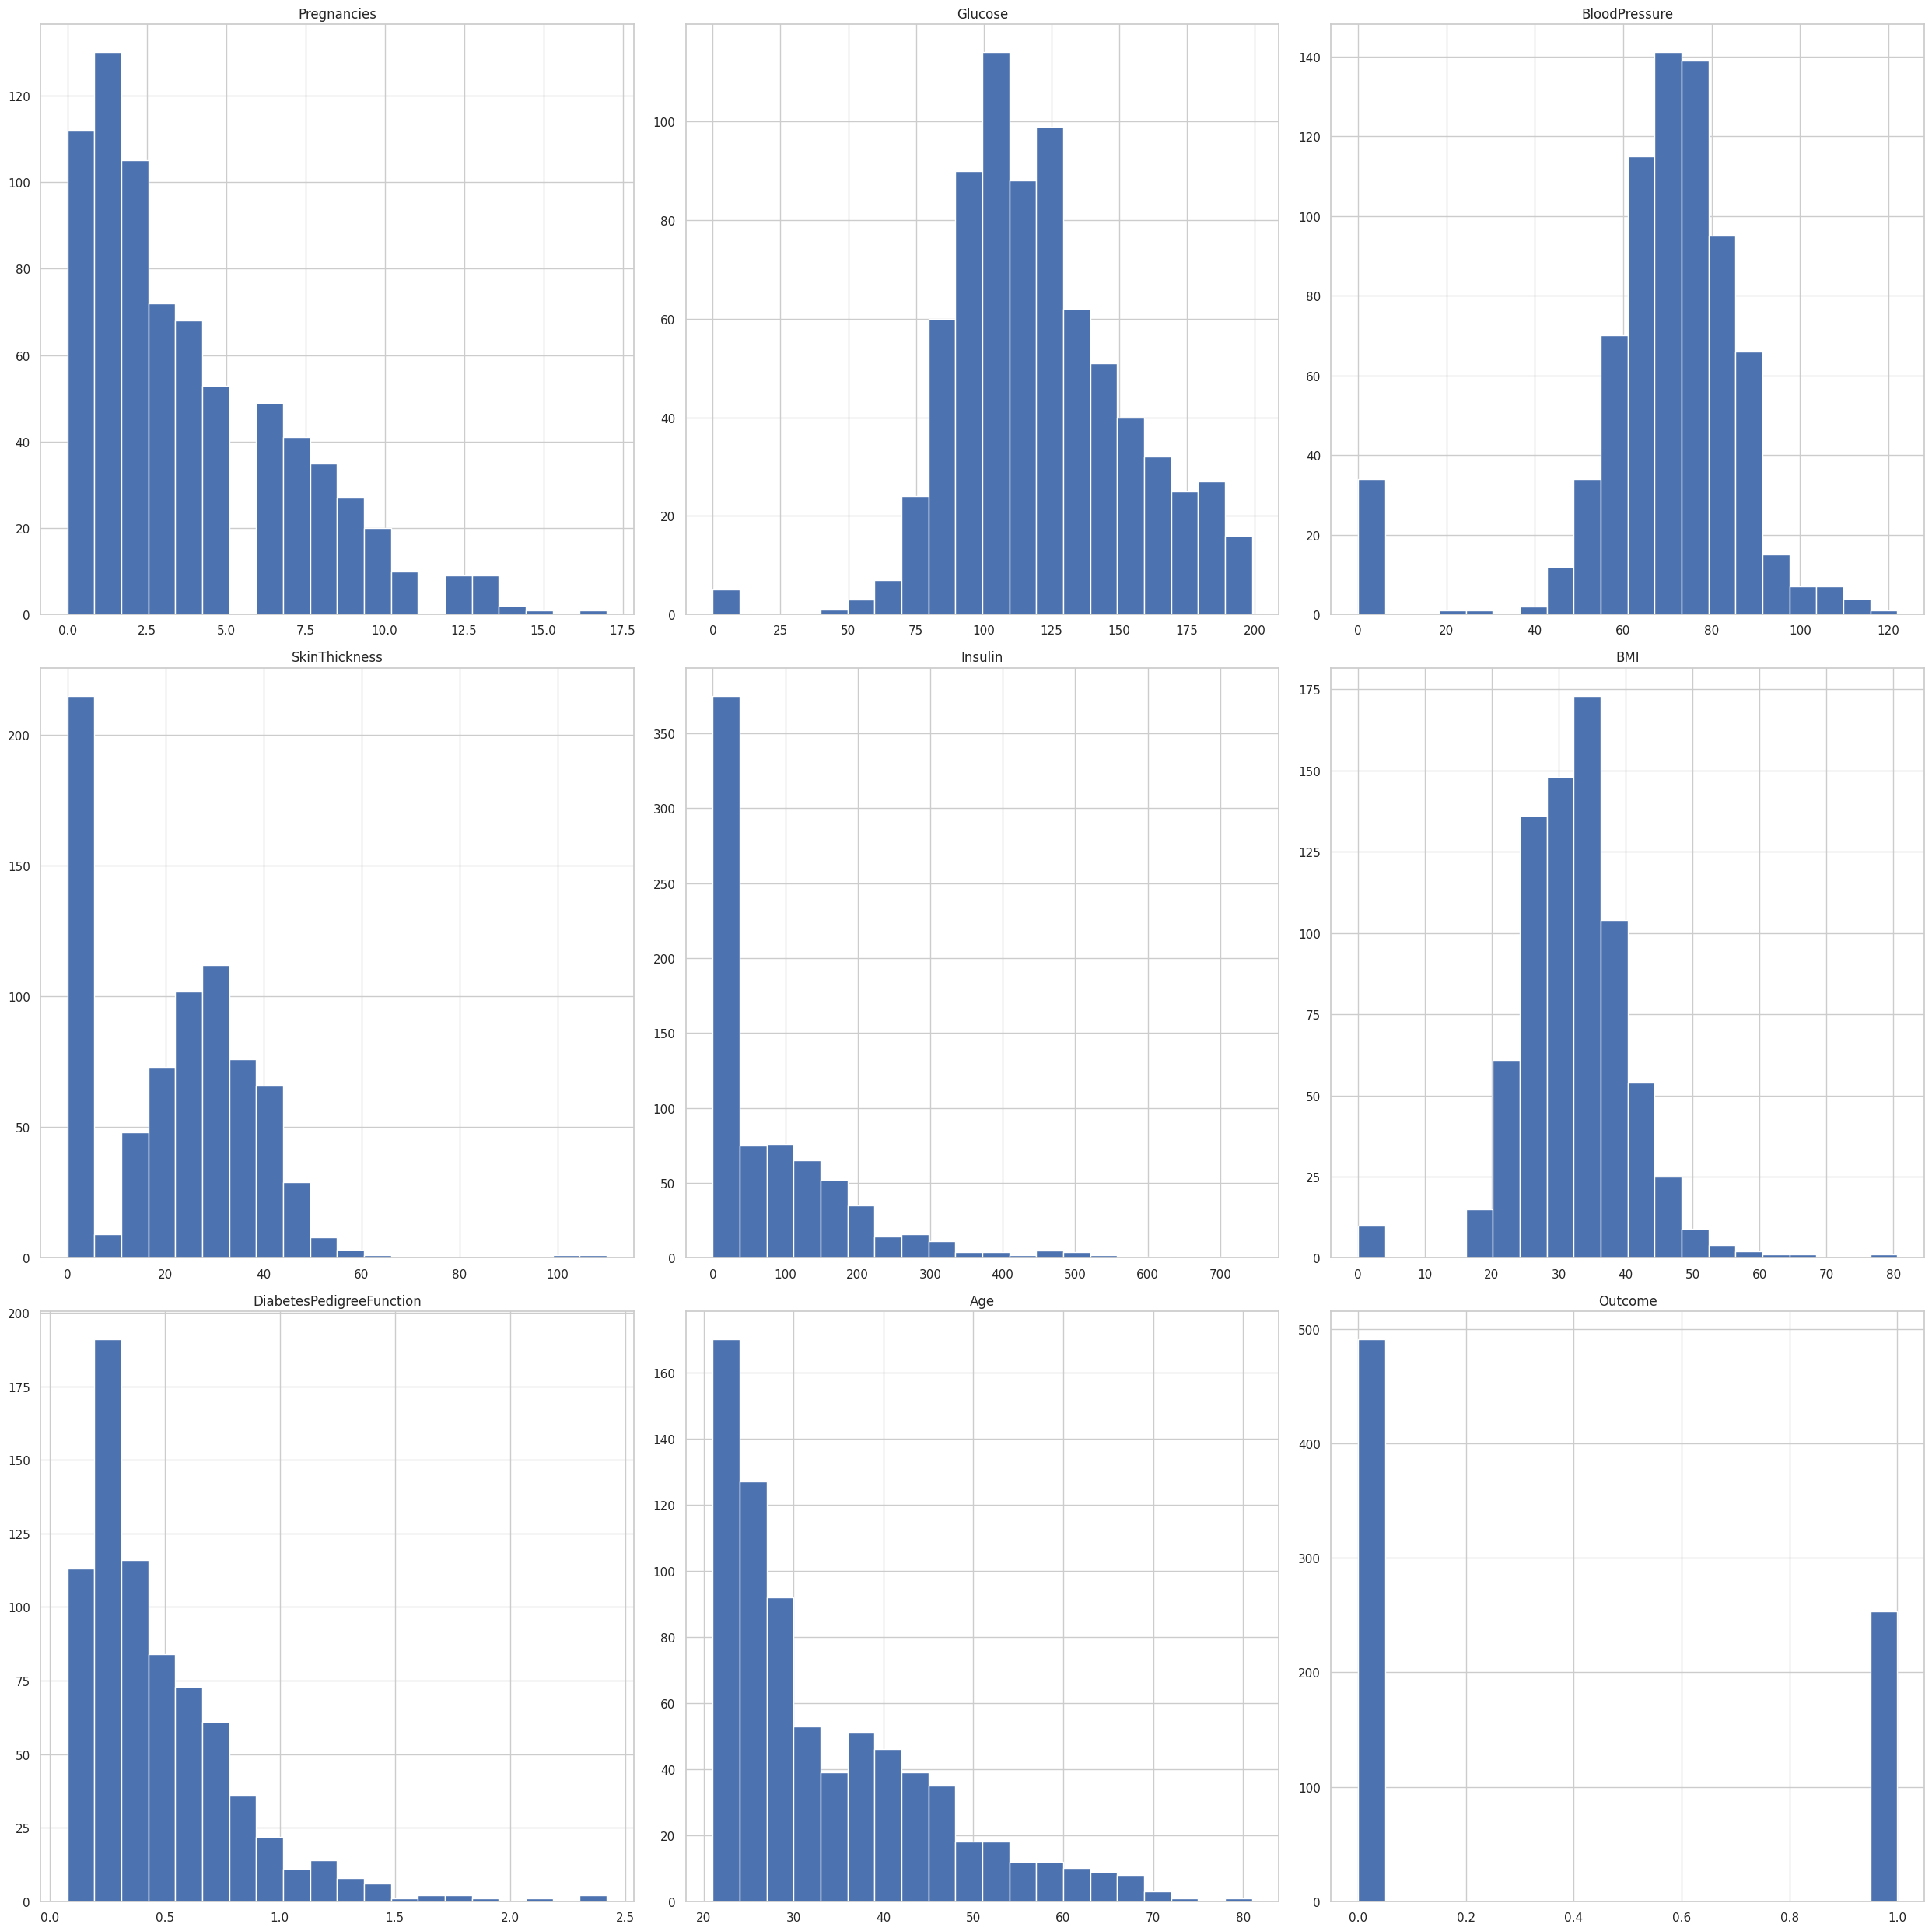

In [18]:
# Генерирует гистограммы для всех числовых столбцов в DataFrame
df.hist(figsize=(25, 25), bins=20)
plt.tight_layout() # Улучшает размещение подграфиков чтобы они не пересекались
plt.show();

In [20]:
df.corr(numeric_only=True)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.117050,0.144284,-0.062530,-0.055783,0.025621,-0.024800,0.536657,0.220942
Glucose,0.117050,1.000000,0.137616,0.070855,0.325135,0.239693,0.133669,0.248673,0.453939
BloodPressure,0.144284,0.137616,1.000000,0.189010,0.091822,0.272704,0.051479,0.242559,0.078808
SkinThickness,-0.062530,0.070855,0.189010,1.000000,0.436080,0.367853,0.184098,-0.103400,0.075562
Insulin,-0.055783,0.325135,0.091822,0.436080,1.000000,0.205365,0.202825,-0.063747,0.114655
BMI,0.025621,0.239693,0.272704,0.367853,0.205365,1.000000,0.124132,0.053336,0.278123
DiabetesPedigreeFunction,-0.024800,0.133669,0.051479,0.184098,0.202825,0.124132,1.000000,0.033321,0.174688
Age,0.536657,0.248673,0.242559,-0.103400,-0.063747,0.053336,0.033321,1.000000,0.242077
Outcome,0.220942,0.453939,0.078808,0.075562,0.114655,0.278123,0.174688,0.242077,1.000000


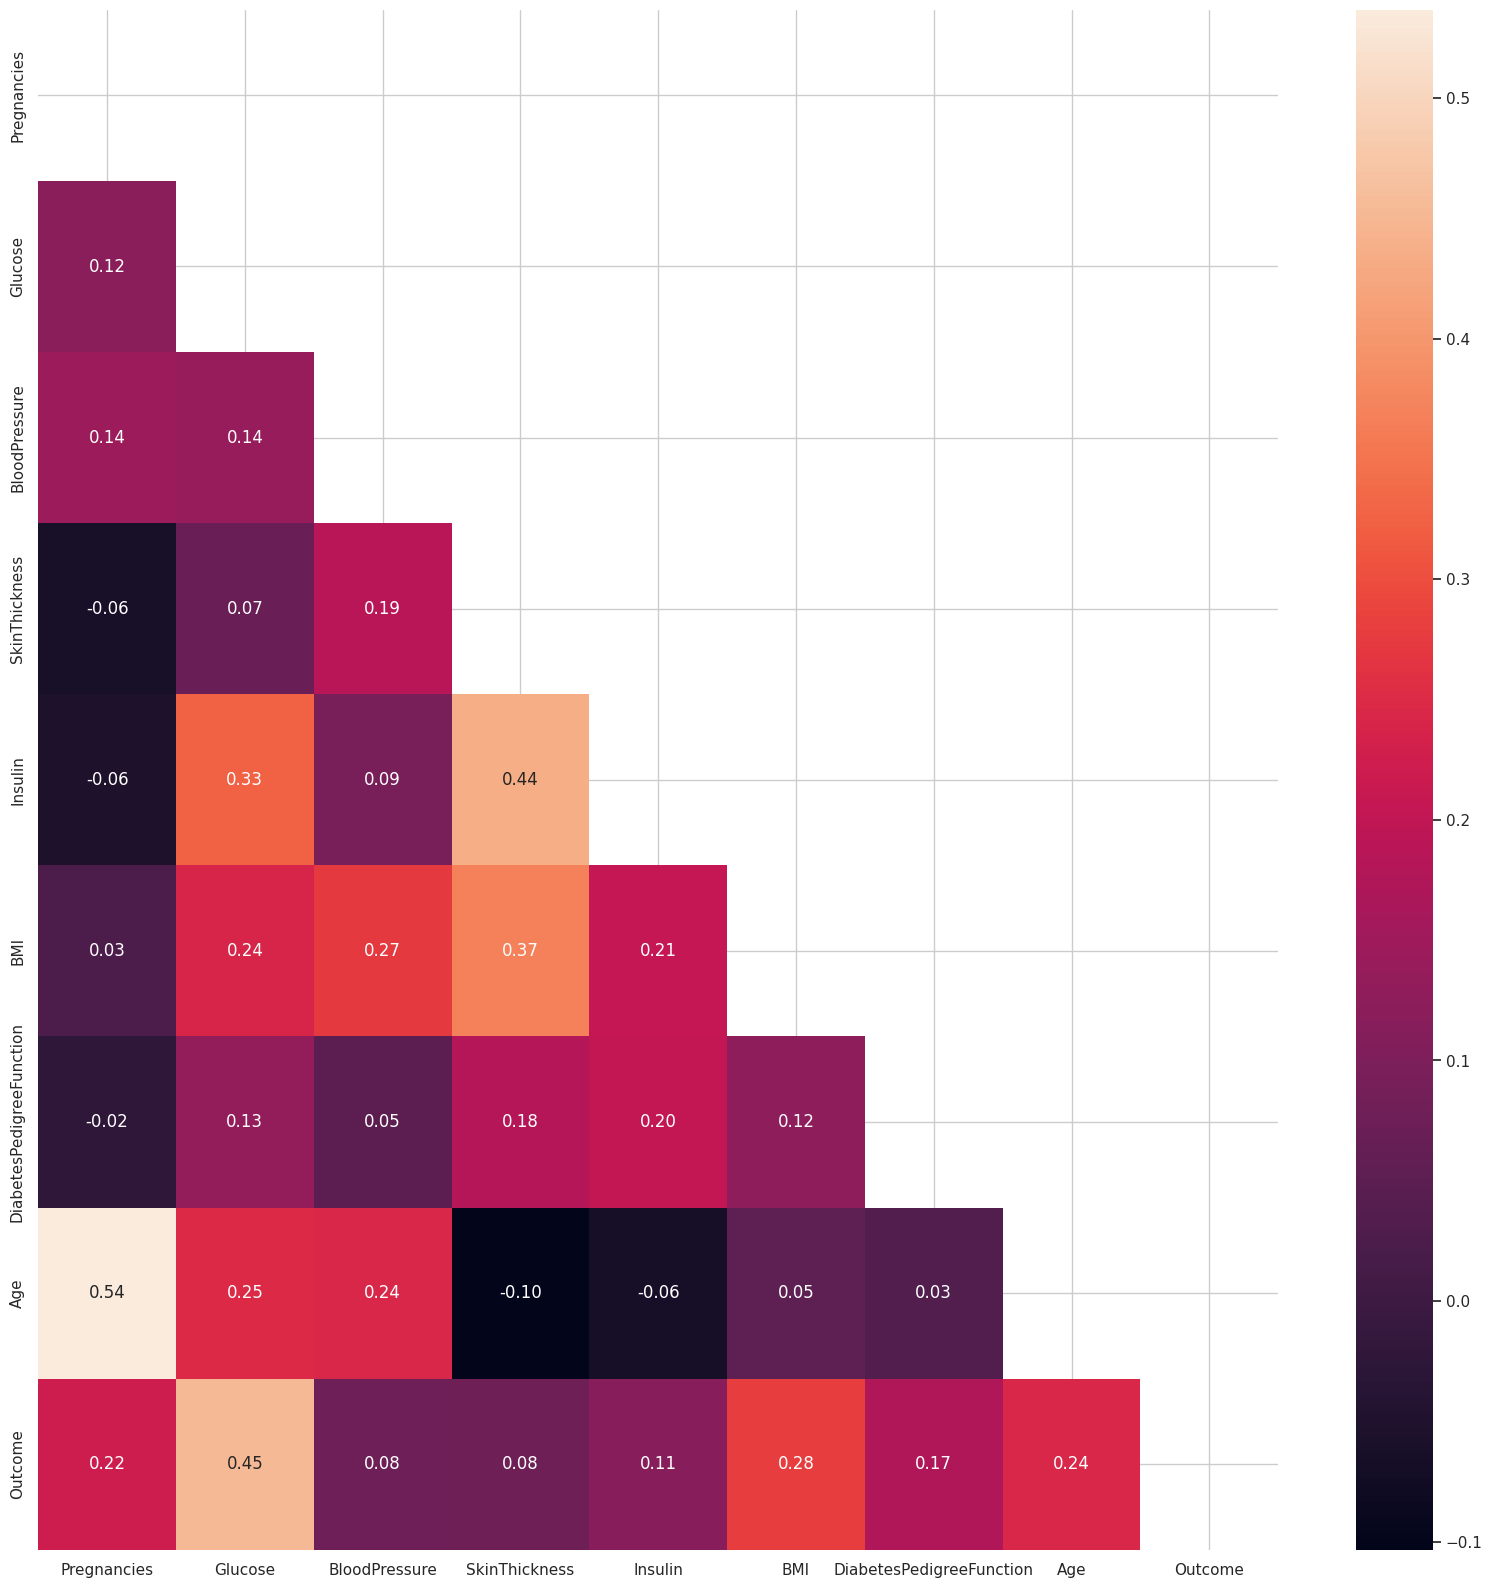

In [22]:
plt.subplots(figsize=(20, 20))
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))
sns.heatmap(df.corr(numeric_only=True), mask=mask, annot = True, fmt = ".2f")
plt.show();

In [25]:
# Вернем наш датасет в исходное состояние - без категориальных столбцов, которые мы добавили.
df1 = df._get_numeric_data()

In [27]:
# Предварительная обработка данных
scaler = StandardScaler()
X = df1.drop('Outcome', axis=1)
X_scaled = scaler.fit_transform(X)
y = df1['Outcome']

# Создание и обучение модели логистической регрессии
lg = LogisticRegression()
lg.fit(X_scaled, y)

# После обучения модели можно получить коэффициенты\
lg.coef_

array([[ 0.39048182,  1.06035228, -0.1621858 ,  0.01416982, -0.15553793,
         0.59481659,  0.3379731 ,  0.18305826]])

In [28]:
feature_names = X.columns
coefficients = lg.coef_[0]  # lg.coef_ возвращает массив в массиве, если модель обучена на двухмерном X

# Связывание имен признаков с их коэффициентами
feature_importances = zip(feature_names, coefficients)

# Преобразование в список для более удобного отображения
feature_importance_list = list(feature_importances)

# Отображение признаков и их коэффициентов
for feature, coef in feature_importance_list:
    print(f"{feature}: {coef}")

Pregnancies: 0.3904818161038539
Glucose: 1.060352276103502
BloodPressure: -0.16218579635427588
SkinThickness: 0.014169824868218396
Insulin: -0.15553793215430575
BMI: 0.5948165878943251
DiabetesPedigreeFunction: 0.3379730990930735
Age: 0.18305825643333315


In [30]:
from sklearn.metrics import accuracy_score

In [31]:
X = df[['Age', 'Glucose']]  # Выбираем признаки
y = df['Outcome']  # Целевая переменная

X_train, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
model1 = LogisticRegression(class_weight='balanced')
model1.fit(X_train, y_train)

predictions1 = model1.predict(X_test1)
accuracy1 = accuracy_score(y_test, predictions1)
print("Accuracy:", accuracy1)

Accuracy: 0.7449664429530202


In [69]:
X = df[['Glucose', 'Pregnancies', 'DiabetesPedigreeFunction']]  # Выбираем признаки
y = df['Outcome']  # Целевая переменная

X_train, X_test2, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
model2 = LogisticRegression(class_weight='balanced')
model2.fit(X_train, y_train)

predictions2 = model2.predict(X_test2)
accuracy2 = accuracy_score(y_test, predictions2)
print("Accuracy:", accuracy2)

Accuracy: 0.7583892617449665


In [61]:
X = df[['BMI', 'DiabetesPedigreeFunction', 'Glucose']]  # Выбираем признаки
y = df['Outcome']  # Целевая переменная

X_train, X_test3, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
model3 = LogisticRegression(class_weight='balanced')
model3.fit(X_train, y_train)

predictions3 = model3.predict(X_test3)
accuracy3 = accuracy_score(y_test, predictions3)
print("Accuracy:", accuracy3)

Accuracy: 0.7516778523489933


In [71]:
X_scaled  # Выбираем признаки
y = df['Outcome']  # Целевая переменная

X_train, X_test4, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [72]:
model4 = LogisticRegression(class_weight='balanced')
model4.fit(X_train, y_train)

predictions4 = model4.predict(X_test4)
accuracy4 = accuracy_score(y_test, predictions4)
print("Accuracy:", accuracy4)

Accuracy: 0.7315436241610739


In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
models = {
    'Model 1': model1,
    'Model 2': model2,
    'Model 3': model3,
    'Model 4': model4
}

test_datasets = {
    'Model 1': X_test1,
    'Model 2': X_test2,
    'Model 3': X_test3,
    'Model 4': X_test4
}

results = []

for model_name, model in models.items():
    X_test = test_datasets[model_name]
    y_pred = model.predict(X_test)
    scores = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='binary'),
        recall_score(y_test, y_pred, average='binary'),
        f1_score(y_test, y_pred, average='binary')
    ]
    results.append(scores)

# Создаем DataFrame для результатов
results_df = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=models.keys())

In [74]:
results_df

,Accuracy,Precision,Recall,F1
Model 1,0.744966,0.571429,0.695652,0.627451
Model 2,0.758389,0.583333,0.760870,0.660377
Model 3,0.751678,0.571429,0.782609,0.660550
Model 4,0.731544,0.550000,0.717391,0.622642


По результатам видно, что модель 3 идеально отрабатывает. Все метрики имеют достаточно хорошие значения. В данной модели, в отличие от других моделей, были учтены почти все признаки из датасета, имеющие огромное воздействие на появление диабета у человека. В нашем случае упор был сделан на метрику recall(значение равно 0.78)

Понимание метрик модели:

1. Точность (Accuracy):
   - Определение: Точность измеряет долю правильных предсказаний среди всех предсказаний.
   $$
   Точность = \frac{TP + TN}{TP + TN + FP + FN},
   $$
 где:

 TP - истино-положительные,  
 TN - истино-отрицательные,  
 FP - ложно-положительные,
 FN - ложно-отрицательные результаты.

   - Почему важна: Точность дает общую оценку того, насколько хорошо модель справляется с задачей предсказания.
   
2. Полнота (Recall):
   - Определение: Полнота измеряет, какую долю из всех реально положительных случаев модель смогла корректно предсказать. $$Полнота = \frac{TP}{TP + FN}$$

.
   - Почему важна: Полнота важна для оценки способности модели находить все потенциальные случаи депрессии. Особенно критично в медицинских условиях, где пропущенный положительный случай может иметь серьезные последствия.

3. Точность (Precision):
   - Определение: Точность измеряет, какая доля предсказанных как положительные случаи действительно являются положительными. $$Точность = \frac{TP}{TP + FP}$$

.
   - Почему важна: Точность показывает, насколько надежными являются предсказания модели. В контексте депрессии важно минимизировать ложно-положительные случаи, чтобы избежать ненужного стресса или лечения для пациентов.

4. F1-мера:
   - Определение: F1-мера - это гармоническое среднее между точностью и полнотой, которое пытается учесть обе метрики одновременно.
$$F1 = 2 \cdot \frac{Точность \cdot Полнота}{Точность + Полнота}$$

.
   - Почему важна: F1-мера важна, когда необходимо найти баланс между точностью и полнотой, особенно в ситуациях, когда классы несбалансированы.

Использование нескольких метрик для оценки является важным, поскольку каждая метрика имеет свои ограничения и сфокусирована на определенном аспекте производительности модели. Точность, например, может быть вводящей в заблуждение в случае сильного дисбаланса классов, в то время как полнота не учитывает ложно-положительные результаты. Использование комплекса метрик обеспечивает более полное понимание производительности модели и ее пригодности для решения конкретной задачи.


**Вывод:**

Модель 2 имеет наивысшую точность (Accuracy) 75,84%, что делает её лучшей среди рассмотренных моделей, если судить только по этой метрике. F1-значение 0.660377 также является наивысшим, наряду с F1-значением у модели 3, что указывает на лучший баланс между Precision и Recall в этой модели по сравнению с другими.

Модель 3 имеет чуть меньшую точность 75,17%, а её F1-значение очень близко к Модели 2 и составляет 0.660550. Модель 3 имеет самый высокий Recall 0.782609 среди всех моделей, что указывает на то, что она лучше других моделей находит истинные случаи заболеваний диабетом, но это также приводит к меньшей точности (Precision)

Модель 1 имеет точность 74,5%, показатель Precision у моделей 1 и 3 равны. однако F1-значение у модели 1 меньше, чем у модели 3.

Модель 4 имеет самую меньшую точность по сравнению с остальными моделями (73, 15%) и остальные метрики этой модели также являются минимальными по сравнению с остальными.

В заключение, на основе представленных данных, Модели 2 и 3 представляют собой наилучшее сочетание точности (Accuracy), точности (Precision) и Recall для задачи определения людей с заболеванием диабета.